1. Imports

In [1]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
#%load_ext watermark

In [3]:
# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [4]:
# Print versions
%watermark --author "Eduarda & Fernando" --date --time --python --machine --iversion --watermark 

UsageError: Line magic function `%watermark` not found.


2. Importing data & connectivity matrix

In [5]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=200):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*_connectivity_matrix.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels

# Example usage:
"""
# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 200 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=200)

# Now you can proceed with the visualization functions
"""

"\n# Set up paths\nresults_dir = '/user_data/csimmon2/git_repos/ptoc/results'\n\n# Create figures directory if it doesn't exist\nos.makedirs(f'{results_dir}/figures', exist_ok=True)\n\n# Load 200 ROI data\nmatrix, region_labels = load_matrices_simple(results_dir, n_rois=200)\n\n# Now you can proceed with the visualization functions\n"


Found 19 Schaefer matrices
Array shape: (19, 200, 200)
Final averaged matrix shape: (200, 200)


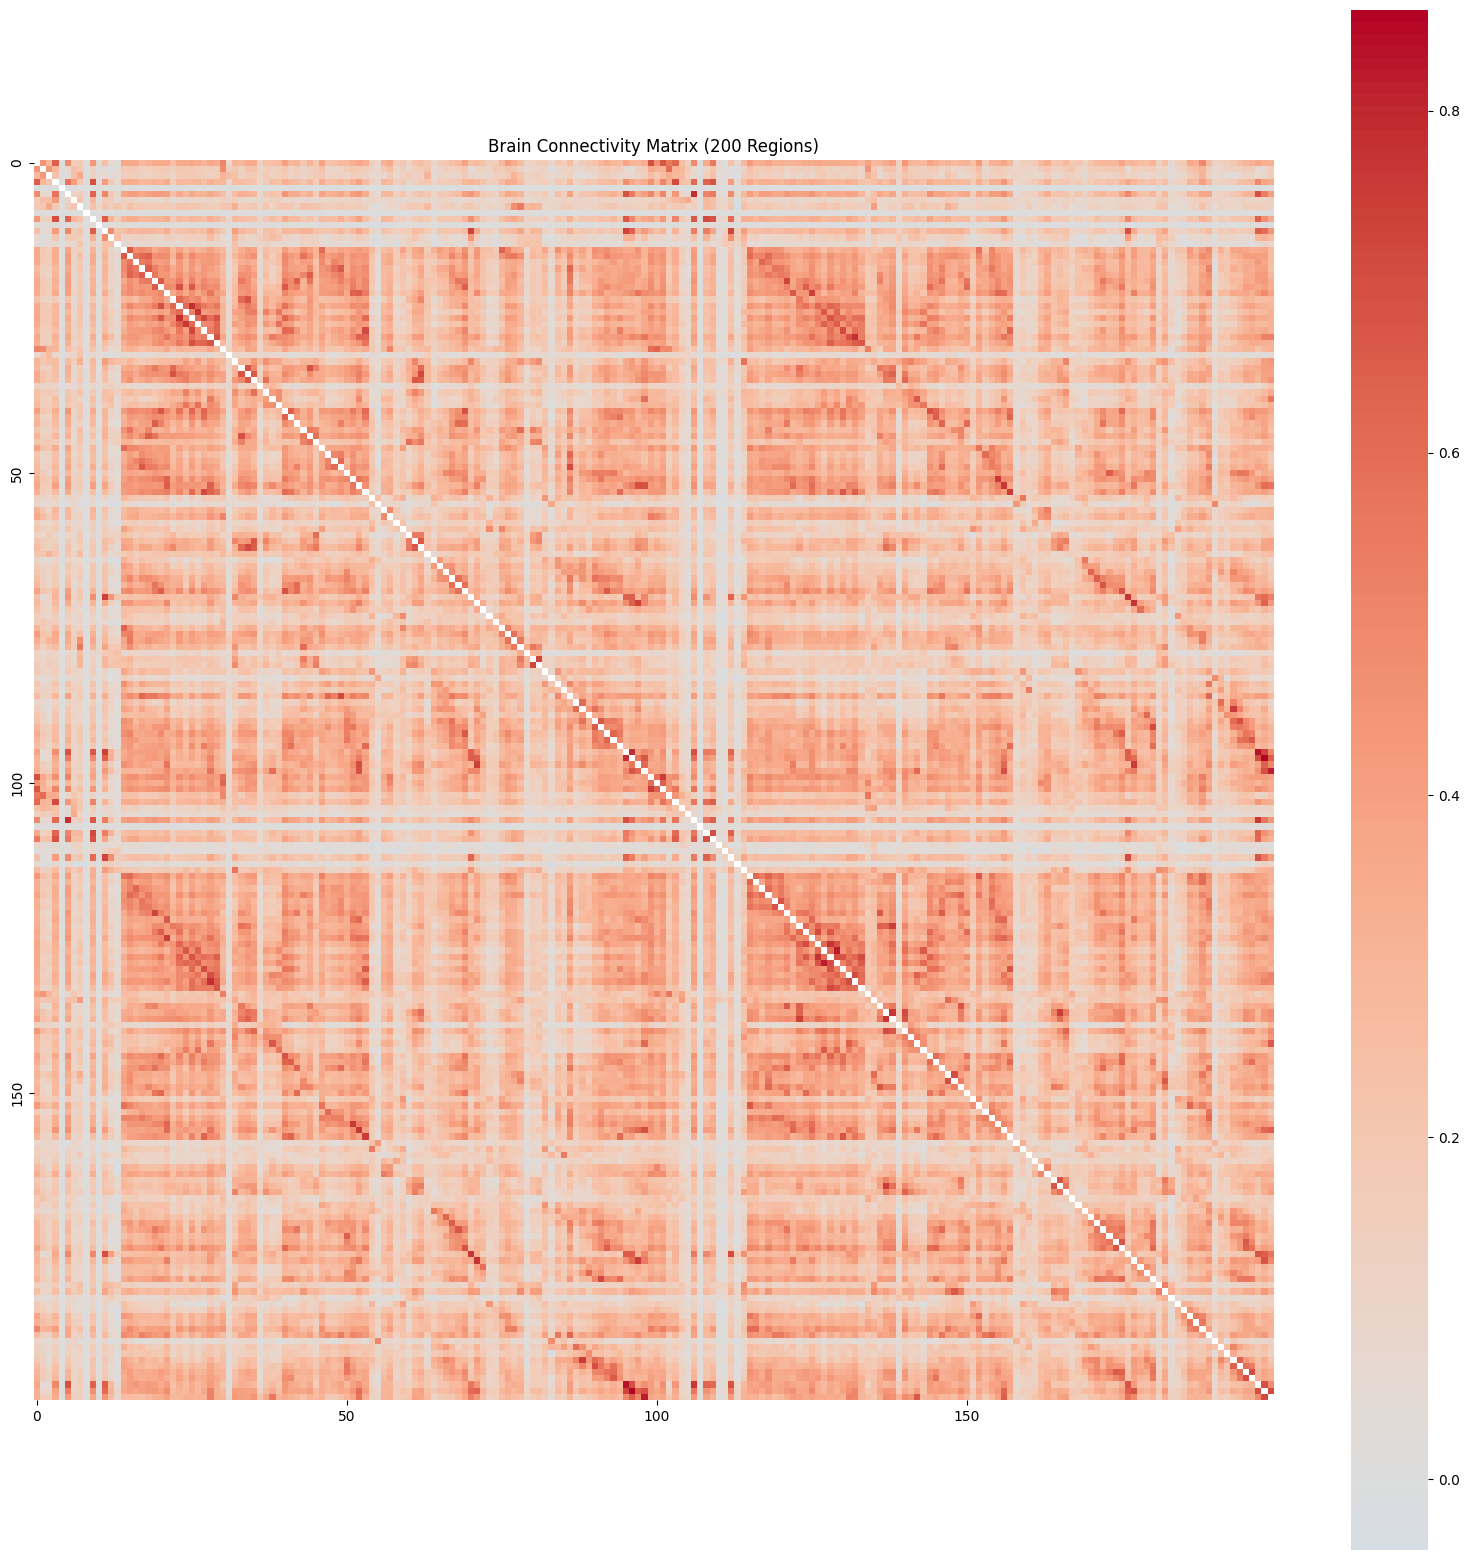

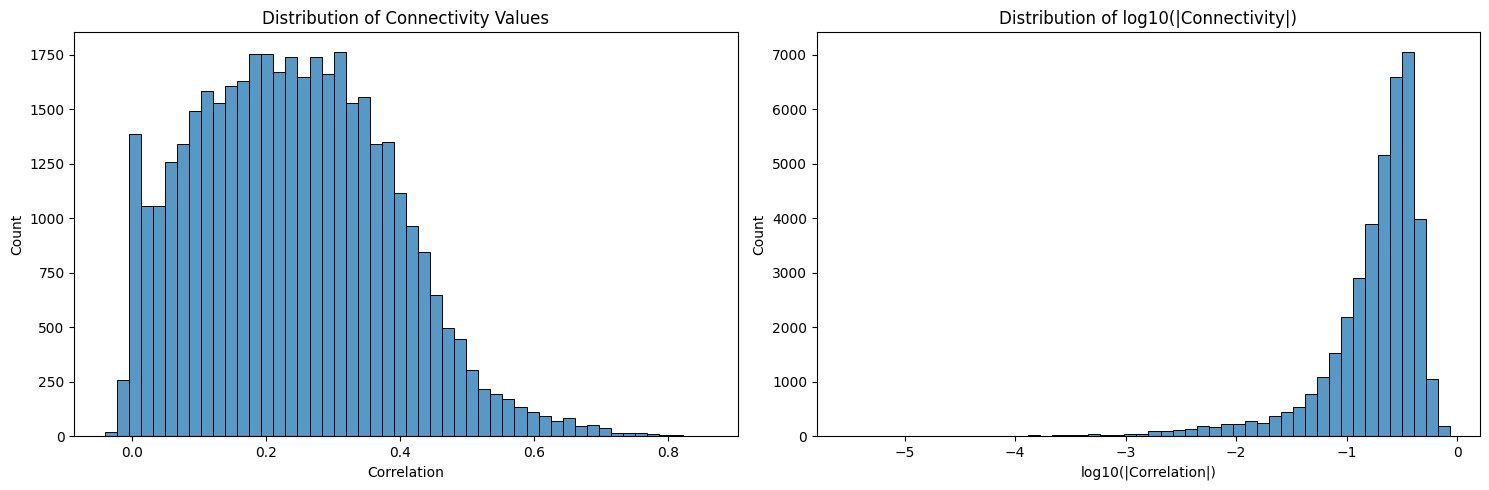

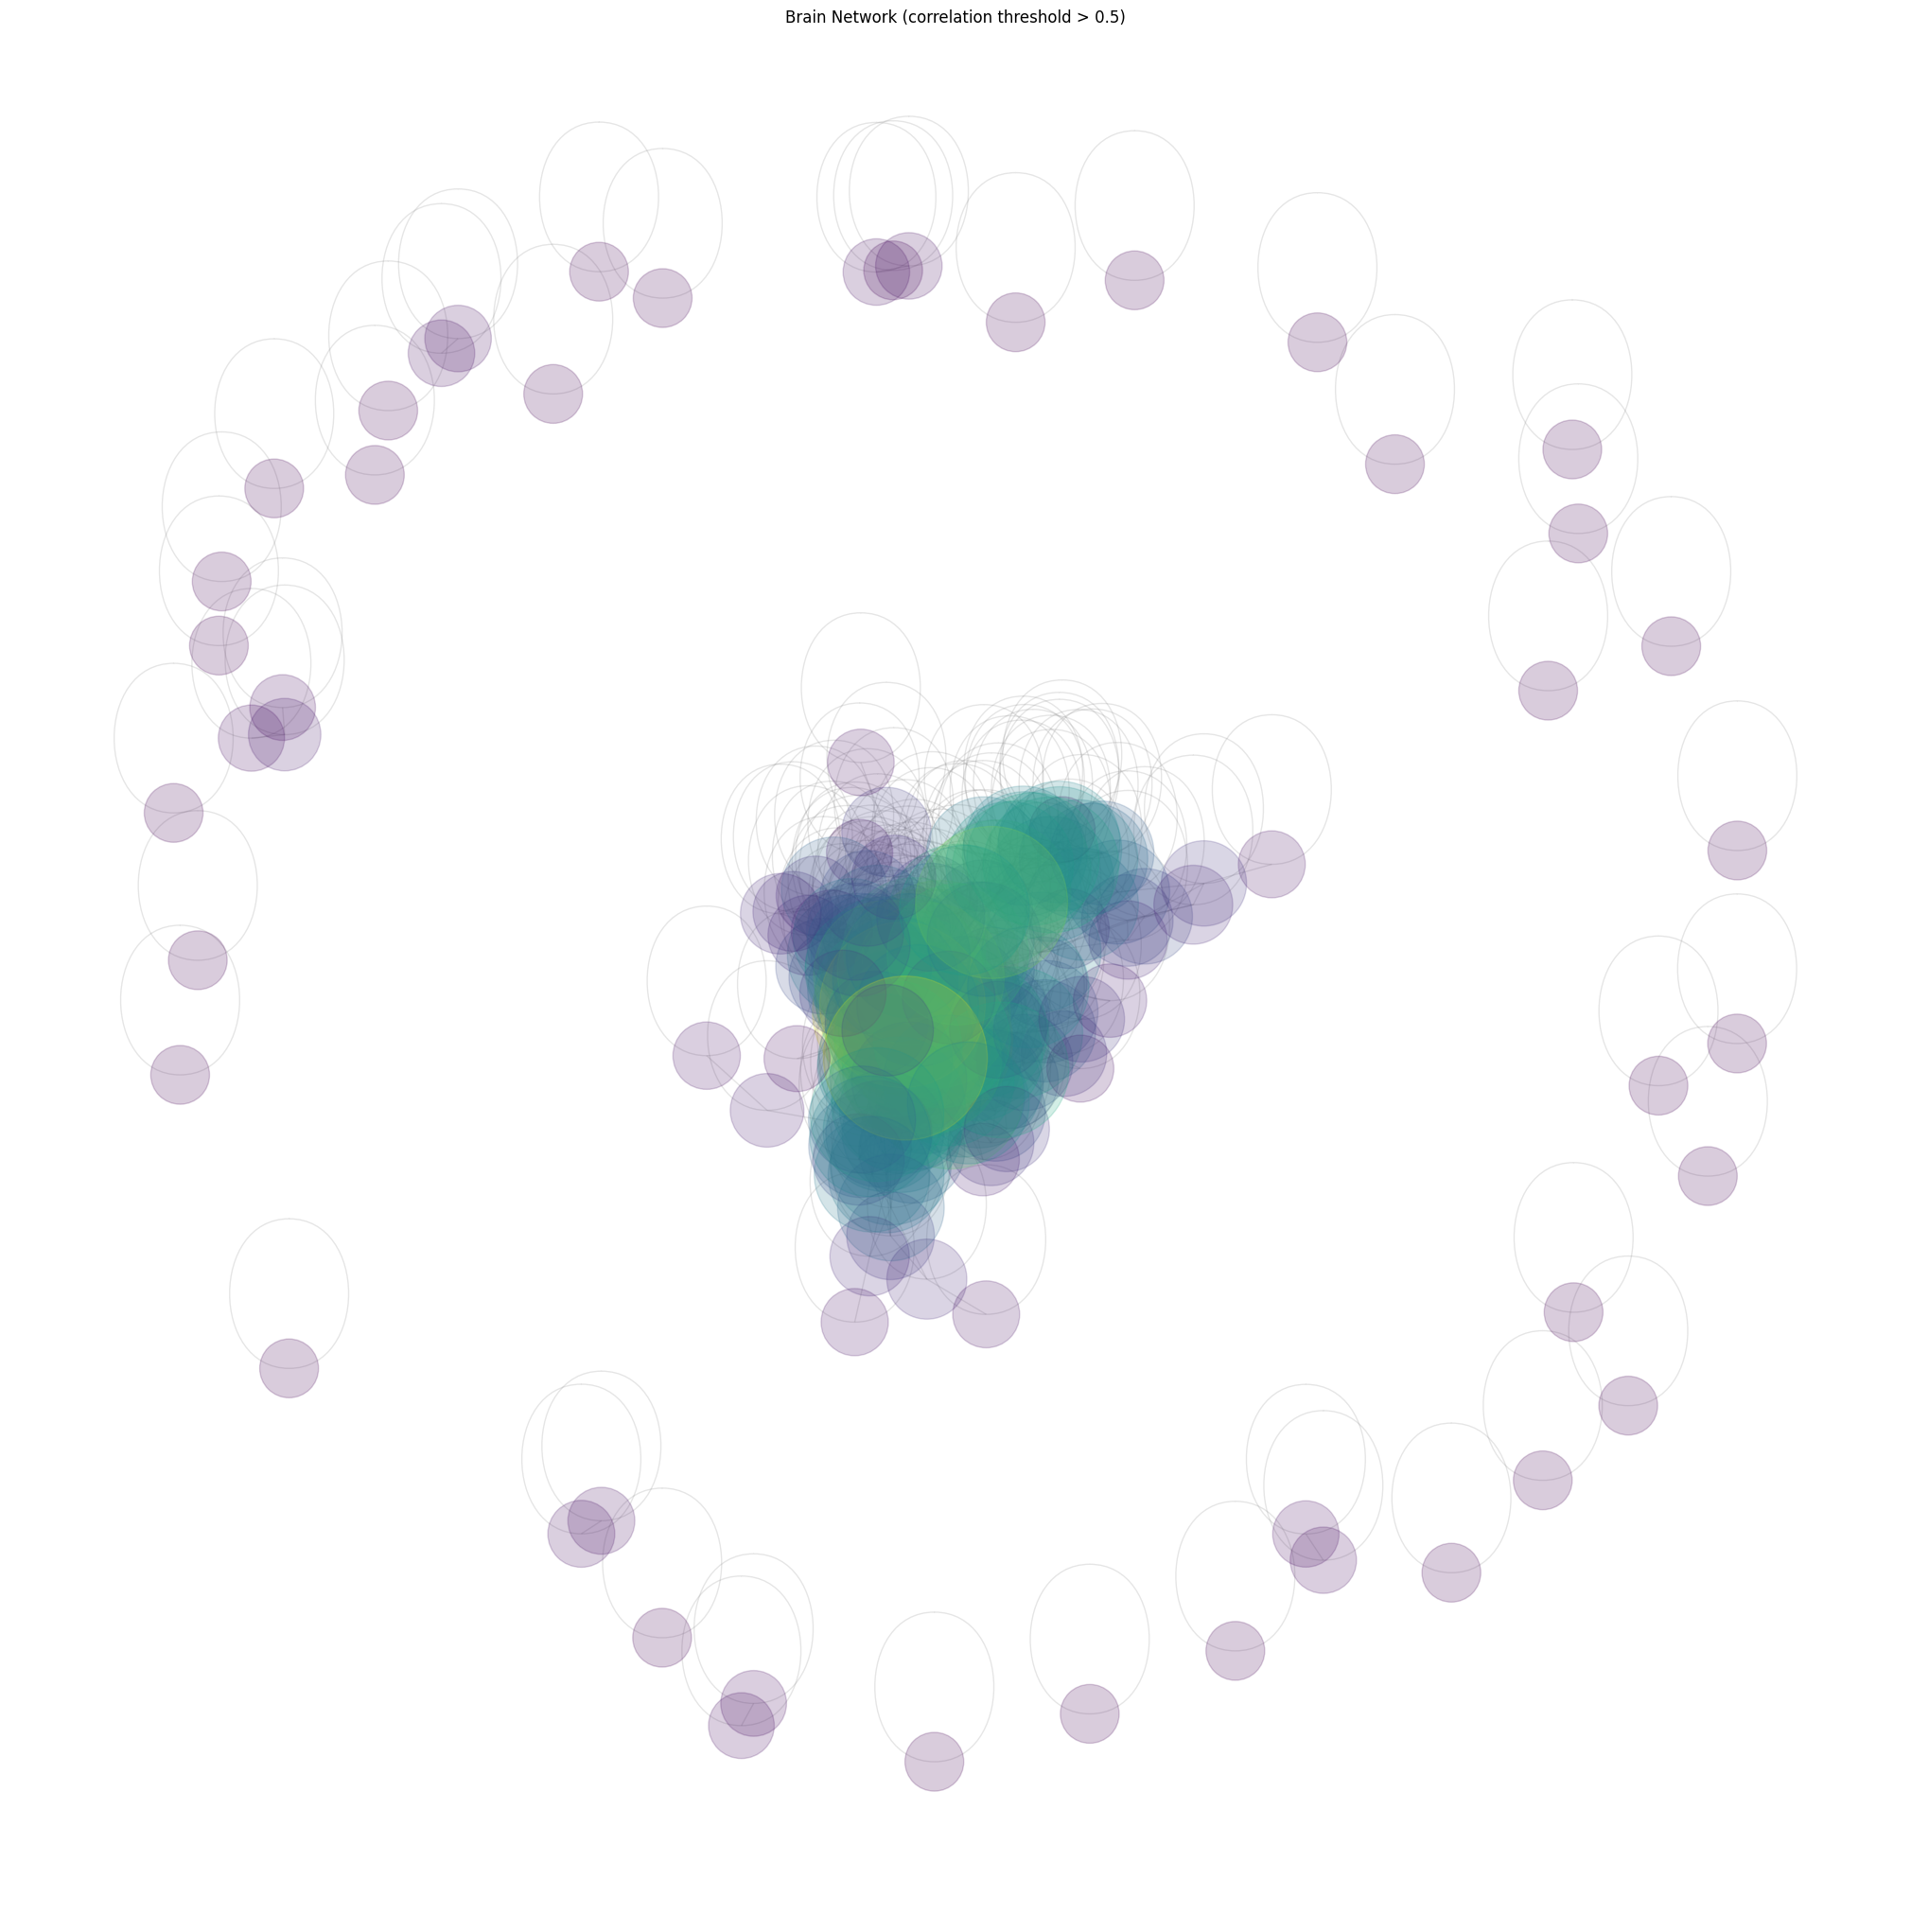

<Figure size 2000x2000 with 0 Axes>

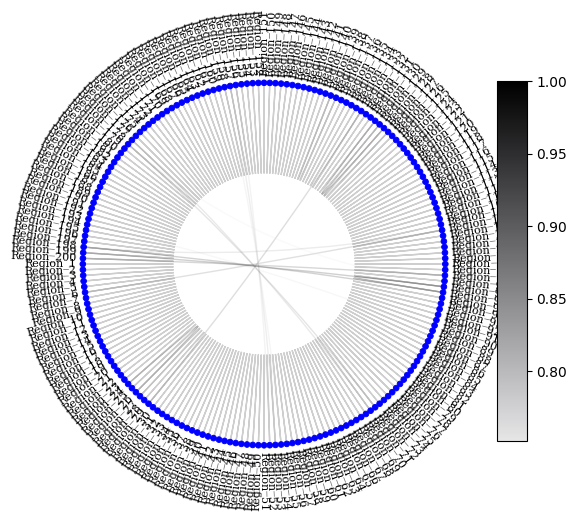

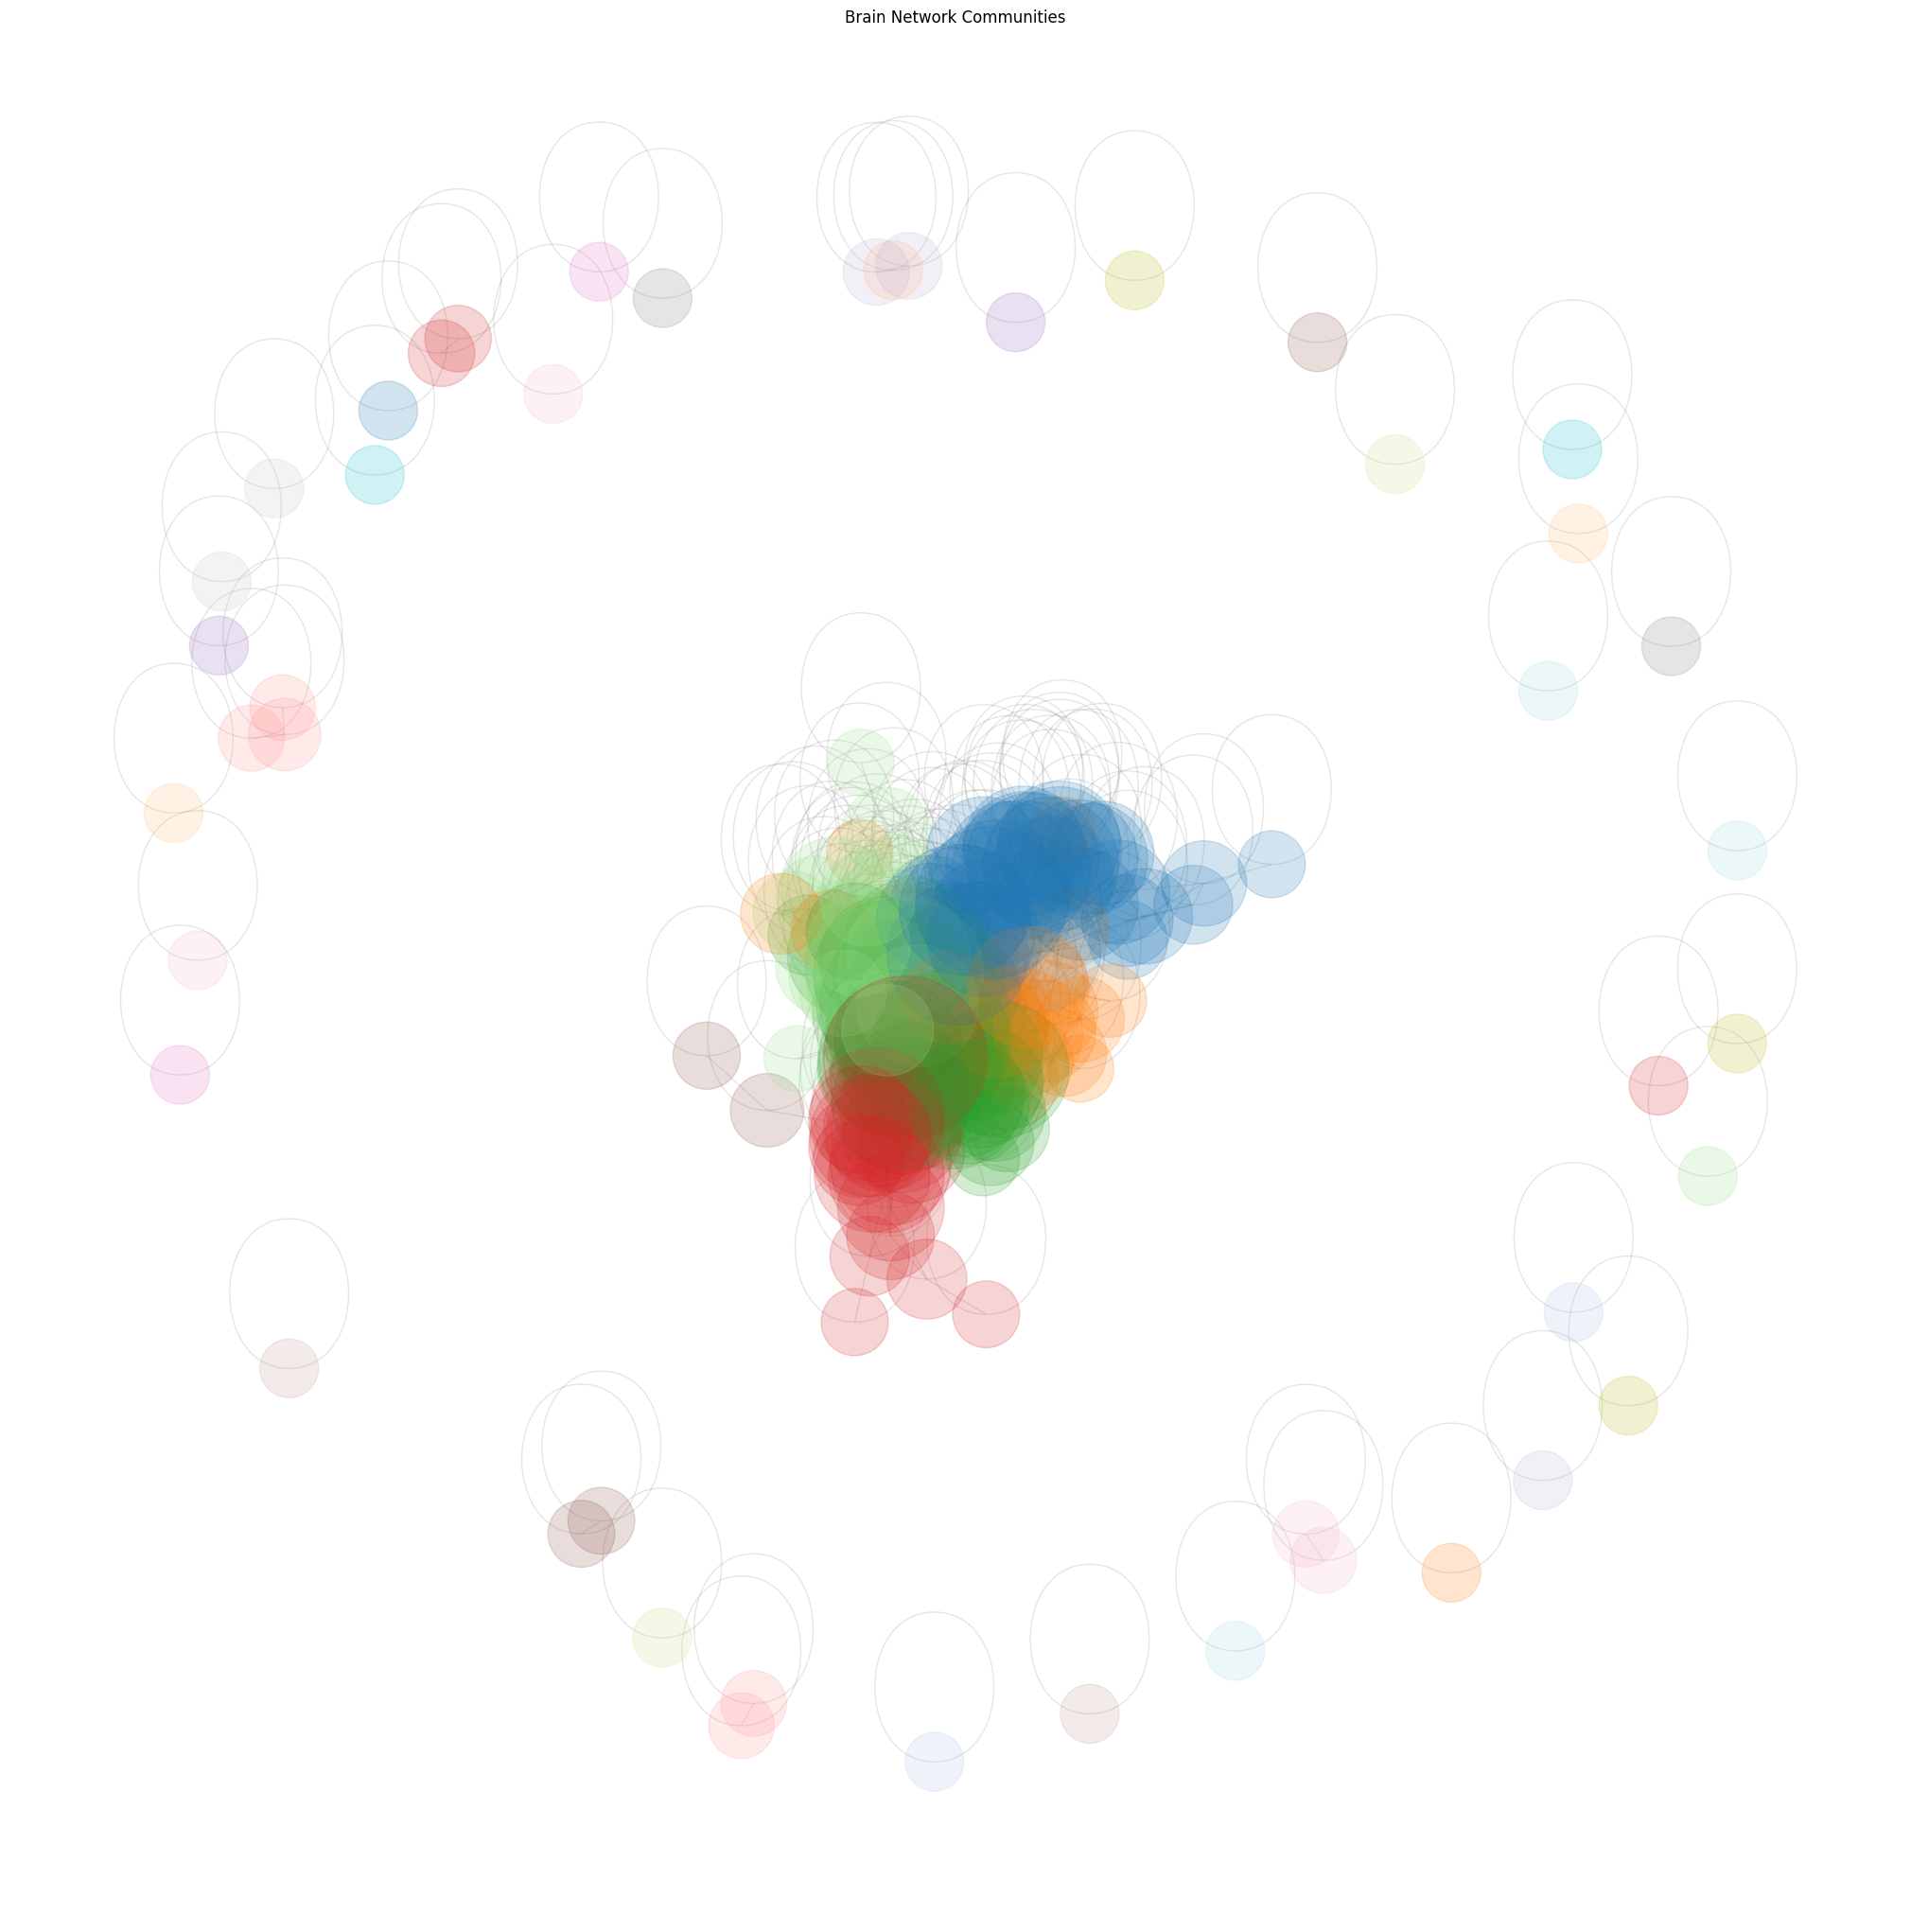

In [20]:
#visualization suite
def create_all_visualizations(matrix, region_labels, results_dir):
    """
    Create all visualizations from the tutorial with corrected parameters
    """
    # 1. Basic Heatmap (Tutorial Fig 1)
    plt.figure(figsize=(20, 20))
    matrix_plot = matrix.copy()
    np.fill_diagonal(matrix_plot, np.nan)
    sns.heatmap(matrix_plot, 
                cmap='coolwarm',
                center=0,
                square=True,
                xticklabels=50,
                yticklabels=50)
    plt.title('Brain Connectivity Matrix (200 Regions)')
    
    # 2. Distribution Plots (Tutorial Fig 2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Flatten matrix excluding diagonal
    flat_matrix = matrix_plot[~np.isnan(matrix_plot)]
    
    # Raw distribution
    sns.histplot(flat_matrix, bins=50, ax=ax1)
    ax1.set_title('Distribution of Connectivity Values')
    ax1.set_xlabel('Correlation')
    ax1.set_ylabel('Count')
    
    # Log10 distribution
    sns.histplot(np.log10(np.abs(flat_matrix)), bins=50, ax=ax2)
    ax2.set_title('Distribution of log10(|Connectivity|)')
    ax2.set_xlabel('log10(|Correlation|)')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    
    # 3. Network Graph (Tutorial Fig 3)
    G = nx.from_numpy_array(matrix)
    threshold = 0.5  # Adjust as needed
    
    # Remove weak connections
    for (u, v, d) in list(G.edges(data=True)):
        if abs(d['weight']) < threshold:
            G.remove_edge(u, v)
            
    # Calculate node strengths
    node_strength = dict(nx.degree(G, weight='weight'))
    node_sizes = [abs(v) * 1000 for v in node_strength.values()]
    
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    # Draw network with corrected parameters
    nx.draw(G, pos,
            node_size=node_sizes,
            node_color=list(node_strength.values()),
            cmap=plt.cm.viridis,
            edge_color='gray',
            alpha=0.2,  # This applies to both nodes and edges
            with_labels=False)
    plt.title(f'Brain Network (correlation threshold > {threshold})')
    
    # 4. Circos Plot (Tutorial Fig 4)
    G_sparse = nx.from_numpy_array(matrix)
    threshold = 0.75  # Higher threshold for clearer visualization
    
    for (u, v, d) in list(G_sparse.edges(data=True)):
        if abs(d['weight']) < threshold:
            G_sparse.remove_edge(u, v)
    
    G_sparse = nx.relabel_nodes(G_sparse, 
                               {i: region_labels[i] for i in range(len(region_labels))})
    
    plt.figure(figsize=(20, 20))
    c = CircosPlot(G_sparse,
                   node_labels=True,
                   node_label_layout='rotation',
                   edge_color="weight",
                   edge_cmap="coolwarm",
                   fontsize=8)
    c.draw()
    
    # 5. Community Detection Plot (Tutorial Fig 5)
    communities = community.best_partition(G)
    
    plt.figure(figsize=(20, 20))
    nx.draw(G, pos,
            node_color=[communities[n] for n in G.nodes()],
            cmap=plt.cm.tab20,
            node_size=node_sizes,
            edge_color='gray',
            alpha=0.2,  # This applies to both nodes and edges
            with_labels=False)
    plt.title('Brain Network Communities')

# Run the visualization
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load your 200 ROI data
matrix, region_labels = load_and_prepare_data(results_dir, n_rois=200)

# Create all visualizations
create_all_visualizations(matrix, region_labels, results_dir)

# Show all plots
plt.show()


Found 19 Schaefer matrices
Array shape: (19, 200, 200)
Final averaged matrix shape: (200, 200)


ValueError: ('Contradictory paths found:', 'negative weights?')

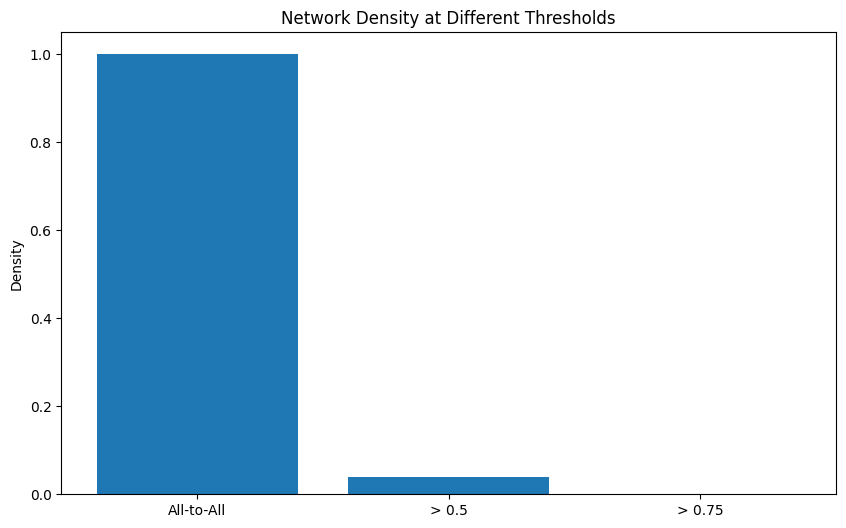

In [24]:
#graph theory analysis and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community
from nxviz import CircosPlot
import warnings
warnings.filterwarnings('ignore')

def create_graph_theory_visualizations(matrix, region_labels, results_dir):
    """
    Create all visualizations from Section 3 (Graph Theory)
    """
    # Create base graph
    G = nx.from_numpy_array(matrix)
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    
    # 1. Network Density Comparison
    # Create graphs with different thresholds
    matrix2 = matrix.copy()
    matrix3 = matrix.copy()
    matrix2[matrix2<=0.50] = 0
    matrix3[matrix3<=0.75] = 0
    
    st50G = nx.from_numpy_array(matrix2)
    st25G = nx.from_numpy_array(matrix3)
    st50G.remove_edges_from(list(nx.selfloop_edges(st50G)))
    st25G.remove_edges_from(list(nx.selfloop_edges(st25G)))
    
    densities = {
        'All-to-All': nx.density(G),
        '> 0.5': nx.density(st50G),
        '> 0.75': nx.density(st25G)
    }
    
    plt.figure(figsize=(10, 6))
    plt.bar(densities.keys(), densities.values())
    plt.title('Network Density at Different Thresholds')
    plt.ylabel('Density')
    #plt.savefig(f'{results_dir}/figures/06_network_density.png')
    #plt.close()
    
    # 2. Centrality Measures
    # Calculate different centrality measures
    centrality_measures = {
        'Closeness': nx.closeness_centrality(G, distance='weight'),
        'Betweenness': nx.betweenness_centrality(G, weight='weight'),
        'Eigenvector': nx.eigenvector_centrality(G, weight='weight'),
        'PageRank': nx.pagerank(G, weight='weight')
    }
    
    # Plot distributions of centrality measures
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    for (measure, values), ax in zip(centrality_measures.items(), axes.flat):
        sns.histplot(list(values.values()), bins=30, ax=ax)
        ax.set_title(f'{measure} Centrality')
        ax.set_xlabel('Centrality Value')
        ax.set_ylabel('Count')
    plt.tight_layout()
    #plt.savefig(f'{results_dir}/figures/07_centrality_distributions.png')
    #plt.close()
    
    # 3. Clustering Coefficient
    clustering = nx.clustering(G, weight='weight')
    plt.figure(figsize=(10, 6))
    sns.histplot(list(clustering.values()), bins=30)
    plt.title('Clustering Coefficient Distribution')
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('Count')
    #plt.savefig(f'{results_dir}/figures/08_clustering_coefficient.png')
    #plt.close()
    
    # 4. Minimum Spanning Tree
    # Create MST visualization
    GMST = nx.minimum_spanning_tree(G, weight='distance')
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(GMST)
    nx.draw(GMST, pos, 
            with_labels=False,
            node_size=100,
            node_color='blue',
            edge_color='gray',
            alpha=0.7)
    plt.title('Minimum Spanning Tree')
    #plt.savefig(f'{results_dir}/figures/09_minimum_spanning_tree.png')
    #plt.close()
    
    # 5. Community Structure with Node Sizes
    communities = community.best_partition(G)
    clustering_values = list(nx.clustering(G, weight='weight').values())
    
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G)
    nx.draw(G, pos,
            node_color=[communities[n] for n in G.nodes()],
            node_size=[v * 9000 for v in clustering_values],
            cmap=plt.cm.Spectral,
            edge_color='grey',
            width=[d['weight']**2 for (u,v,d) in G.edges(data=True)],
            alpha=0.7)
    plt.title('Community Structure with Node Sizes Based on Clustering')
    #plt.savefig(f'{results_dir}/figures/10_community_clustering.png')
    #plt.close()
    plt_show()
    
    return G, centrality_measures, communities

# Example usage:
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix, region_labels = load_and_prepare_data(results_dir)
G, centrality_measures, communities = create_graph_theory_visualizations(matrix, region_labels, results_dir)

In [ ]:
#topology and geometry analysis and visualization
import numpy as np
import matplotlib.pyplot as plt
import gudhi
import networkx as nx
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

def create_topology_visualizations(matrix, region_labels, results_dir):
    """
    Create all visualizations from Section 4 (Topology & Geometry)
    """
    # 1. Persistent Homology
    # Convert correlation to distance matrix
    mattop = 1 - np.abs(matrix)
    
    # Compute persistence diagram
    rips_complex = gudhi.RipsComplex(distance_matrix=mattop, max_edge_length=1)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    
    # Plot persistence barcode
    plt.figure(figsize=(12, 8))
    gudhi.plot_persistence_barcode(diag, legend=True)
    plt.title('Persistence Barcode')
    plt.savefig(f'{results_dir}/figures/11_persistence_barcode.png')
    plt.close()
    
    # Plot persistence diagram
    plt.figure(figsize=(12, 8))
    gudhi.plot_persistence_diagram(diag, legend=True)
    plt.title('Persistence Diagram')
    plt.savefig(f'{results_dir}/figures/12_persistence_diagram.png')
    plt.close()
    
    # Plot persistence density
    plt.figure(figsize=(12, 8))
    gudhi.plot_persistence_density(diag, dimension=1)
    plt.title('Persistence Density')
    plt.savefig(f'{results_dir}/figures/13_persistence_density.png')
    plt.close()
    
    # 2. Euler Characteristics
    def compute_euler_characteristic(adj_matrix, threshold):
        """Compute Euler characteristic for a given threshold"""
        G = nx.from_numpy_array(adj_matrix > threshold)
        n_nodes = G.number_of_nodes()
        n_edges = G.number_of_edges()
        return n_nodes - n_edges
    
    # Compute Euler characteristics across thresholds
    thresholds = np.linspace(0, 1, 70)
    euler_chars = [compute_euler_characteristic(matrix, t) for t in thresholds]
    
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, euler_chars, '-o')
    plt.xlabel('Threshold')
    plt.ylabel('Euler Characteristic')
    plt.title('Euler Characteristic vs. Threshold')
    plt.savefig(f'{results_dir}/figures/14_euler_characteristic.png')
    plt.close()
    
    # 3. Curvature Distribution
    def compute_node_curvature(G):
        """Compute curvature for each node"""
        curvature = []
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            if len(neighbors) > 1:
                subgraph = G.subgraph(neighbors)
                local_edges = subgraph.number_of_edges()
                possible_edges = (len(neighbors) * (len(neighbors) - 1)) / 2
                curv = (2 * local_edges) / (len(neighbors) * (len(neighbors) - 1)) if possible_edges > 0 else 0
                curvature.append(curv)
            else:
                curvature.append(0)
        return curvature
    
    # Compute curvature for thresholded network
    G_threshold = nx.from_numpy_array(matrix > 0.7)
    curvature_values = compute_node_curvature(G_threshold)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(curvature_values, bins=30)
    plt.title('Node Curvature Distribution')
    plt.xlabel('Curvature')
    plt.ylabel('Count')
    plt.savefig(f'{results_dir}/figures/15_curvature_distribution.png')
    plt.close()

# Example usage:
"""
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix, region_labels = load_and_prepare_data(results_dir)
create_topology_visualizations(matrix, region_labels, results_dir)
"""